In [1]:
import json
import pandas as pd
import networkx as nx
import numpy as np
import networkx as nx
import community
import matplotlib.pyplot as plt
import csv

In [2]:
from twitter import *

In [11]:
# Loading my authentication tokens
with open('auth_dict','r') as f:
    twtr_auth = json.load(f)

# To make it more readable, lets store
# the OAuth credentials in strings first.
CONSUMER_KEY = twtr_auth['consumer_key']
CONSUMER_SECRET = twtr_auth['consumer_secret']
OAUTH_TOKEN = twtr_auth['token']
OAUTH_TOKEN_SECRET = twtr_auth['token_secret']
    
# Then, we store the OAuth object in "auth"
auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)
# Notice that there are four tokens - you need to create these in the
# Twitter Apps dashboard after you have created your own "app".

# We now create the twitter search object.
t = Twitter(auth=auth)

In [12]:
import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [13]:
# This will let us create new partial
# functions with arguments set to 
# certain values.
from functools import partial

# This was maxint.
# There is no longer a maxint (in Python 3)
from sys import maxsize


def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=100, followers_limit=100):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=100)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=100)
    friends_ids, followers_ids = [], []
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        #LOOK HERE! This little line is important.
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),
                    label, (user_id or screen_name), file=sys.stderr))
            if len(ids) >= limit or response is None:
                break
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]


In [14]:
# Create a mostly empty data frame,
# and write it to a CSV file.
df = pd.DataFrame(columns=['ID','followers'])
df.to_csv('followers.csv', index=False)

# Our function
def save_followers(fid, followers):
    df = pd.DataFrame([[fid, followers]], columns=['ID','followers'])
    with open('followers.csv', 'a') as f:
        df.to_csv(f,header=False, index=False)

In [15]:
#G = nx.Graph()
result = set()

already = []

def crawl_followers(twitter_api, screen_name, limit=100, depth=5):
    
    # Resolve the ID for screen_name and start working with IDs for consistency
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    friends , followers = get_friends_followers_ids(twitter_api, user_id=seed_id,
                        friends_limit=limit, followers_limit=limit)
    
    reciprocals = set(friends) & set(followers)
    # Store a seed_id => _follower_ids mapping in MongoDB
    seed_id = int(seed_id)
    next_queue = top_five_reciprocals(twitter_api, user_ids=reciprocals)
    save_followers(seed_id, ','.join([str(x) for x in next_queue]))
    #G.add_node(seed_id)
    result.add(seed_id)
    
    already.append(seed_id)

    for x in next_queue:
            
            #G.add_node(x)
            #G.add_edge(seed_id,x)
            result.add(x)
    d = 1
    # Note that in the example in the next cell,
    # we never enter this loop.
    while d < depth:
        if(len(result) >100):
            return
        d += 1
        # Reset the next_queue so that we can
        # start building up the next level
        # of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        # Loop through the current
        # level of followers
        for fid in queue:
            if(len(result) >100):
                return
            if not(fid in already):
                friends_ids, follower_ids = get_friends_followers_ids(twitter_api, user_id=fid,
                                    friends_limit=limit, followers_limit=limit)
                # Store an ID with a string recording
                # IDs of followers of the user with ID "fid"
                reciprocals2 = set(friends_ids) & set(follower_ids)
                next_queue1 = top_five_reciprocals(twitter_api, user_ids=reciprocals2)
                save_followers(str(fid), ','.join([str(x) for x in next_queue1]))

                for x in next_queue1:
                    #G.add_node(x)
                    #G.add_edge(fid , x)
                    result.add(x)
                already.append(fid)

                # Extending the list
                next_queue += next_queue1

In [8]:
def top_five_reciprocals(t, user_ids):
    random = []
    result = set()
    if len(user_ids) <= 0:
        return result
    for elem in user_ids:
        temp = t.users.lookup(user_id = str(elem))[0]['followers_count']
        random.append(temp)
        
    followers_count = dict (zip(user_ids,random))
    temp = sorted(followers_count.items(), key=lambda x: x[1], reverse=True)
    
    for a in temp[:5]:
        result.add(a[0])
    
    return result

In [17]:
screen_name = "jugglinjosh"
crawl_followers(t, screen_name, depth=5, limit=100)

Fetched 100 total friends ids for 186197243
Fetched 100 total followers ids for 186197243
Fetched 100 total friends ids for 926652194744688640
Fetched 100 total followers ids for 926652194744688640
Fetched 100 total friends ids for 1068145002
Fetched 100 total followers ids for 1068145002
Fetched 100 total friends ids for 789534265
Fetched 100 total followers ids for 789534265
Fetched 100 total friends ids for 1075377020
Fetched 100 total followers ids for 1075377020
Fetched 100 total friends ids for 497334366
Fetched 100 total followers ids for 497334366
Fetched 100 total friends ids for 42174248
Fetched 100 total followers ids for 42174248
Fetched 100 total friends ids for 2398659002
Fetched 100 total followers ids for 2398659002
Fetched 100 total friends ids for 4521642202
Fetched 100 total followers ids for 4521642202
Fetched 100 total friends ids for 214666268
Fetched 100 total followers ids for 214666268
Fetched 100 total friends ids for 965239777
Fetched 100 total followers ids 

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 0 total friends ids for 536853639
Fetched 0 total followers ids for 536853639
Fetched 100 total friends ids for 1152202014
Fetched 100 total followers ids for 1152202014
Fetched 100 total friends ids for 535853951
Fetched 100 total followers ids for 535853951
Fetched 33 total friends ids for 953017653135839232
Fetched 22 total followers ids for 953017653135839232
Fetched 100 total friends ids for 446478284
Fetched 100 total followers ids for 446478284
Fetched 100 total friends ids for 1406619086
Fetched 100 total followers ids for 1406619086
Fetched 100 total friends ids for 2327211503
Fetched 100 total followers ids for 2327211503
Fetched 100 total friends ids for 261313876
Fetched 100 total followers ids for 261313876
Fetched 100 total friends ids for 3106885636
Fetched 100 total followers ids for 3106885636
Fetched 100 total friends ids for 833980555
Fetched 100 total followers ids for 833980555
Fetched 100 total friends ids for 469774093
Fetched 100 total followers ids for 

In [18]:
H = nx.Graph()
with open('followers.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        for edgeTo in row['followers'].split(','):
            if edgeTo != '':
                H.add_edge(row['ID'],edgeTo)

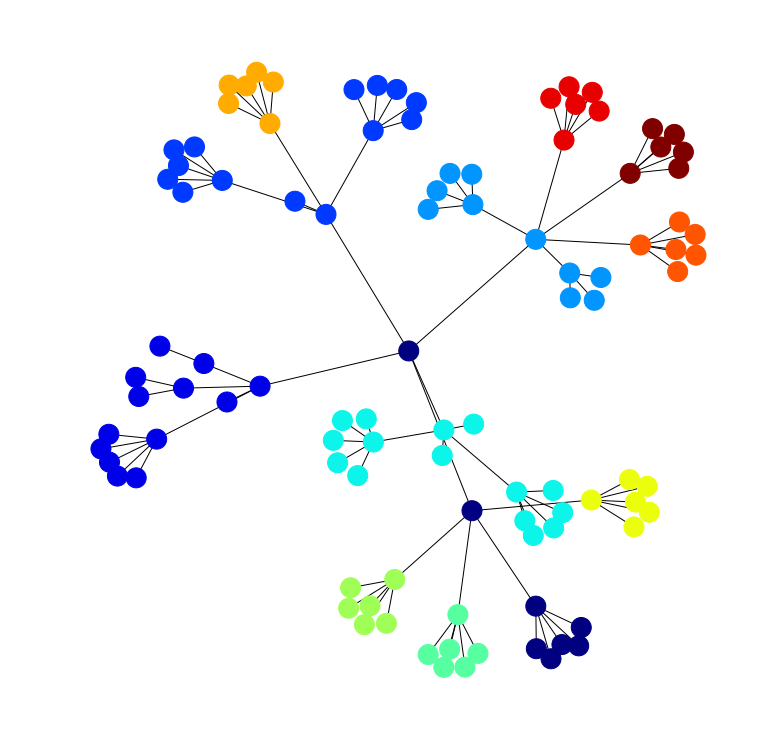

In [19]:
part = community.best_partition(H)
values = [part.get(node) for node in H.nodes()]
plt.figure(figsize=(10,10))

nx.draw_spring(H, cmap = plt.get_cmap('jet'), node_color = values, node_size=400, with_labels=False)
plt.show()

In [20]:
print(result)

{926652194744688640, 953017653135839232, 752801023803228160, 960105098113265664, 3106885636, 816711927732649984, 453855233, 597562375, 817753898169430017, 381328903, 857992562576998400, 811721756251602945, 1239736854, 214666268, 2368008739, 1101826598, 138880551, 848286248, 136592941, 4562979374, 584921648, 4807262775, 789534265, 3387942461, 55753281, 1587446342, 33491029, 294240859, 172669533, 497334366, 1875088477, 486235236, 37599351, 1578185857, 858004415734730752, 536853639, 928495754, 833980555, 717438863803699202, 234943633, 484070036, 1869715104, 4801306274, 819616436, 891201223, 1678917324, 228747982, 4521642202, 1554829021, 231675620, 2557884649, 1332685548, 1641230575, 608348401, 568606451, 3120486132, 186197243, 940266408876892160, 858118046686355456, 2499434755, 977206536, 469774093, 589597976, 1152202014, 42174248, 2453655848, 526839608, 342260540, 2321095486, 2212834627, 2269580101, 167781199, 2379328338, 261313876, 2883370840, 1068145002, 3059650412, 609560429, 77214039

In [21]:
#k_comm_3 = list(nx.community.k_clique_communities(G,2))
nx.algorithms.community.kernighan_lin_bisection(H)

({'1068145002',
  '1075377020',
  '1127036780',
  '1152202014',
  '1332685548',
  '1363474382',
  '136592941',
  '1406619086',
  '1529170417',
  '1542046585',
  '1554829021',
  '1578185857',
  '1587446342',
  '1641230575',
  '186197243',
  '1875088477',
  '228747982',
  '231675620',
  '2321095486',
  '2499434755',
  '252303263',
  '261313876',
  '2883370840',
  '294240859',
  '3059650412',
  '3106885636',
  '3120486132',
  '321552354',
  '377546679',
  '381328903',
  '422808439',
  '453855233',
  '469774093',
  '497334366',
  '526839608',
  '535853951',
  '536853639',
  '55753281',
  '584921648',
  '589597976',
  '608348401',
  '609560429',
  '750180235',
  '789534265',
  '817753898169430017',
  '848286248',
  '857992562576998400',
  '953017653135839232',
  '965233022',
  '965239777',
  '977206536'},
 {'1101826598',
  '1239736854',
  '138880551',
  '14560698',
  '167781199',
  '1678917324',
  '172669533',
  '1869715104',
  '214666268',
  '2212834627',
  '2269580101',
  '2327211503',
  

1. Select a user to start with.
2. Retrieve IDs of that user's friends and followers. These are two lists. You may set the max results, as we have here, to 5000.
3. Use the two lists from 2. in order to find the *reciprocal friends* of the user from 1. These are the *distance-1* friends of that user.
4. From that list of distance-1 friends, select the **5 most popular** as determined by their **followers_count** values in user profiles. Use, for instance, the *get_user_profile* function from *Mining the Social Web*.
5. Repeat steps 2, 3 & 4 for each of the distance-1 friends selected, then distance-2, an so on until you have gathered at least 100 nodes (users) for your social network.